# Alternative Age Model KDE Difference Plots

The purpose of this notebook is to reproduce figures presenting results from our interval statistics analysis using alternative age model methods (Bacon and COPRA). Here we show the application of interval statistic techniques to the median interval values.

Note that this technique will be incorporated into [Pyleoclim](https://pyleoclim-util.readthedocs.io/).

In [1]:
import pickle
import os

import pyleoclim as pyleo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyreadr

from scipy.stats import zscore

In [2]:
# Mapping stalagmites names to cave site names

cave_site_dict = {
    'HS4' : 'Heshang',
#    'SB43' : 'Sanbao',
    'C9961' : 'Jiuxian',
    'LH-2' : 'Lianhua',
    'KMA' : 'Mawmluh',
    'XL26' : 'Xianglong',
    'DA' : 'Dongge',
    'SAH2' : 'Sahiya',
    'Hq-1' : 'Hoq',
#    'D1' : 'Dark',
#    'SN17' : 'Shennong',
    'TA12-2' : 'Tangga',
    'LAVI-4' : 'LaVierge',
    'Q5' : 'Oman'
}

In [3]:
with open('../data/holo_chrons_study.pkl','rb') as handle:
    holo_chrons = pickle.load(handle)

with open('../data/preprocessed_series_dict.pkl','rb') as handle:
    series_dict = pickle.load(handle)

with open('../data/palette_dict.pkl','rb') as handle:
    color_palette = pickle.load(handle)

First applying our technique using the Bacon data:

In [4]:
# Loading the SISAL Bacon data

bacon_dir = '../data/alt_chrons/SISAL_Bacon/'
bacon_files = os.listdir(bacon_dir)
bacon_dict = {}

for file in bacon_files:
    res = pyreadr.read_r(f'{bacon_dir}{file}')
    name = cave_site_dict[file.split('Bacon')[0][:-1]]
    res_key = list(res.keys())[0]
    bacon_dict[name] = res[res_key]

In [5]:
# Pulling the relevant data from the Bacon data

chron_bacon={}
df_bacon={}
df_proxy={}

for site in bacon_dict.keys():
    df_bacon_tmp = bacon_dict[site]
    
    # Create a dictionary to store proxy data for the current site
    dic_proxy={'age':np.asarray(holo_chrons[site]['age']),
            'd18O':np.asarray(holo_chrons[site]['d18O']),
            'depth_sample':np.asarray(holo_chrons[site]['depth'])}

    # Create a dataframe from the proxy data dictionary
    df_proxy_tmp = pd.DataFrame.from_dict(dic_proxy)

    # Multiply the depth_sample column by 10 to match the units in the Bacon data
    df_bacon_tmp['depth_sample'] = df_bacon_tmp['depth_sample'] * 10

    # Preprocess the proxy data for specific sites
    if site == 'Dongge':
        # Group the proxy data by depth_sample and take the mean
        df_proxy_tmp = df_proxy_tmp.groupby('depth_sample').mean().reset_index()

    # Handle specific sites that have different data requirements
    if site in ['Heshang','Mawmluh','Jiuxian','Lianhua','Dark','Hoq']:
        # Assign the Bacon and proxy dataframes directly
        df_bacon[site] = df_bacon_tmp
        df_proxy[site] = df_proxy_tmp
    elif site == 'Sahiya':
        # Exclude the first 24 rows of the Bacon data for Sahiya
        df_bacon[site] = df_bacon_tmp.iloc[24:]
        df_proxy[site] = df_proxy_tmp
    else:
        # Filter the Bacon and proxy dataframes to include only matching depth_sample values
        df_bacon[site] = df_bacon_tmp.loc[df_bacon_tmp['depth_sample'].isin(df_proxy_tmp['depth_sample'])]
        df_proxy[site] = df_proxy_tmp.loc[df_proxy_tmp['depth_sample'].isin(df_bacon_tmp['depth_sample'])]

    # Convert the Bacon dataframe to a numpy array and transpose it to get the chronology
    chron_bacon[site] = df_bacon[site].iloc[:, 2:].to_numpy().T

In [6]:
# detrending and collect d18O values at different intervals

#d18O values at different intervals
d18O_int_bacon={}
#Detrended zscore vals
zscore_detrend={}

# Iterate over each site in the bacon_dict
for site in bacon_dict.keys():
    ty=df_proxy[site]['d18O']
    chron_tmp = chron_bacon[site]
    nC = chron_tmp.shape[0]

    zscore_detrend[site]=np.zeros((nC,len(ty)))
    zscore_detrend[site][:]=np.nan
    
    # Iterate over each chronology for the current site
    for j in range(nC):
        tx=chron_tmp[j,:]
        # detrending by the Pyleoclim detrending function
        ts = pyleo.Series(time=tx, value=ty,dropna=False,verbose=False)
        ts_detrended= ts.detrend(method='savitzky-golay')
        a=ts_detrended.value
        zscore_detrend[site][j,:] = zscore(a,nan_policy='omit')


    d18O_int_bacon[site]={}
    holo_int={}
    # int_size: interval size
    for int_size in [150,200]:
        holo_int[int_size] = np.arange(4000%int_size-int_size/2,10000,int_size)
        d18O_int_bacon[site][int_size]=np.zeros((len(holo_int[int_size])-1,nC))
        d18O_int_bacon[site][int_size][:]=np.nan
        # Iterate over each interval for the current site
        for i in range(len(holo_int[int_size])-1):
            tage = holo_int[int_size][i]
            # Iterate over each chronology for the current site
            for j in range(nC):
                tx=chron_tmp[j,:]
                d18O_int_bacon[site][int_size][i,j]=np.nanmedian(zscore_detrend[site][j,(tx>=tage) & (tx<holo_int[int_size][i+1])])

/Users/alexjames/miniconda3/envs/asc_env/lib/python3.11/site-packages/pyleoclim/utils/tsutils.py:1400: UserWarning: Timeseries is not evenly-spaced, interpolating...
  warnings.warn("Timeseries is not evenly-spaced, interpolating...")
/Users/alexjames/miniconda3/envs/asc_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


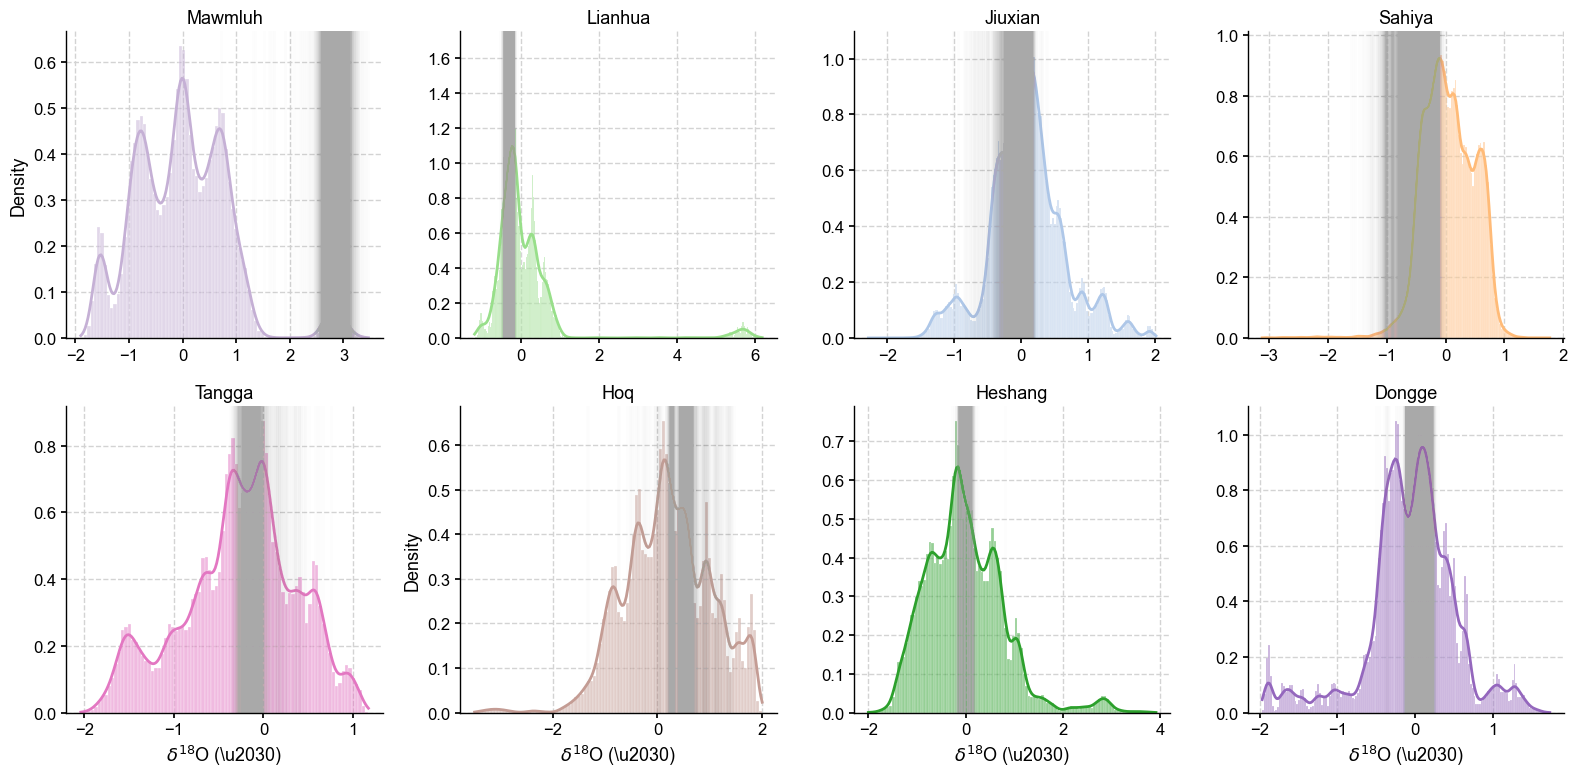

In [7]:
# Plotting

clrs = color_palette

# Create a subplot grid with 4 columns and 2 rows
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(16, 8), tight_layout=True)

# Flatten the axis array for easier indexing
axes = ax.ravel()

int_size = 200

# Iterate over each site in d18O_diff_bacon
for idx, site in enumerate(d18O_int_bacon.keys()):
    # Extract the data for the current site and interval size
    s = pd.Series(d18O_int_bacon[site][int_size].flatten())
    
    # Create a histogram plot using seaborn
    sns.histplot(s.dropna(), color=clrs[site], ax=axes[idx], kde=True, ec='white', stat='density')
    
    # Set the title for each subplot
    axes[idx].set_title(site, fontsize=13)
    
    # Set the y-label for the first column of subplots
    if idx in [0, 5, 10]:
        axes[idx].set_ylabel('Density', fontsize=13)
    else:
        axes[idx].set_ylabel('')
    
    # Set the tick label size for both axes
    axes[idx].tick_params(axis='both', which='major', labelsize=12)
    
    # Set the x-label for the bottom row of subplots
    if idx >= 4:
        axes[idx].set_xlabel(u'$\\delta^{18}$O (\\u2030)', fontsize=13)
    
    # Add vertical lines for each data point in the specified interval
    for i in range(d18O_int_bacon[site][int_size].shape[1]):
        axes[idx].axvline(x=d18O_int_bacon[site][int_size][holo_int[int_size][:-1]==4000-int_size/2, i], alpha=0.01, color='darkgray')

Now onto the COPRA ensembles:

In [8]:
copra_dir = '../../data/alt_chrons/SISAL_COPRA/'
copra_files = os.listdir(copra_dir)
copra_dict = {}

for file in copra_files:
    res = pyreadr.read_r(f'{copra_dir}{file}')
    name = cave_site_dict[file.split('copRa')[0][:-1]]
    res_key = list(res.keys())[0]
    copra_dict[name] = res[res_key]

In [9]:
# Getting the relevant chron data for each site
chron_copra = {}
df_copra = {}
df_proxy = {}

for site in copra_dict.keys():
    # Get the COPRA dataframe for the current site
    df_copra_tmp = copra_dict[site]
    
    # Create a dictionary with the proxy data for the current site
    dic_proxy = {
        'age': np.asarray(holo_chrons[site]['age']),
        'd18O': np.asarray(holo_chrons[site]['d18O']),
        'depth_sample': np.asarray(holo_chrons[site]['depth'])
    }
    
    # Convert the proxy dictionary to a dataframe
    df_proxy_tmp = pd.DataFrame.from_dict(dic_proxy)
    
    # Check if the site is 'Heshang' or 'Mawmluh'
    if site == 'Heshang' or site == 'Mawmluh':
        # If the site is 'Heshang' or 'Mawmluh', directly assign the dataframes
        df_copra[site] = df_copra_tmp
        df_proxy[site] = df_proxy_tmp
    else:
        # If the site is not 'Heshang' or 'Mawmluh', align the depths of the two dataframes
        
        # Filter the COPRA dataframe to include only the rows with depths matching the proxy dataframe
        df_copra[site] = df_copra_tmp.loc[df_copra_tmp['depth_sample'].isin(df_proxy_tmp['depth_sample'])]
        
        # Filter the proxy dataframe to include only the rows with depths matching the COPRA dataframe
        df_proxy[site] = df_proxy_tmp.loc[df_proxy_tmp['depth_sample'].isin(df_copra_tmp['depth_sample'])]
    
    # Extract the chron data from the COPRA dataframe and store it as a numpy array
    chron_copra[site] = df_copra[site].iloc[:, 2:].to_numpy().T

In [10]:
# detrending and collect d18O values at different intervals

#d18O values at different intervals
d18O_int_copra={}
#Detrended zscore vals
zscore_detrend={}

for site in copra_dict.keys():
    ty=df_proxy[site]['d18O']
    chron_tmp = chron_copra[site]
    nC = chron_tmp.shape[0]

    zscore_detrend[site]=np.zeros((nC,len(ty)))
    zscore_detrend[site][:]=np.nan
    
    for j in range(nC):
        tx=chron_tmp[j,:]
        # detrending by the Pyleoclim detrending function
        ts = pyleo.Series(time=tx, value=ty,dropna=False,verbose=False)
        ts_detrended= ts.detrend(method='savitzky-golay')
        a=ts_detrended.value
        zscore_detrend[site][j,:] = zscore(a,nan_policy='omit')

    d18O_int_copra[site]={}
    holo_int={}
    # int_size: interval size
    for int_size in [150,200,250]:
        holo_int[int_size] = np.arange(4000%int_size-int_size/2,10000,int_size)
        d18O_int_copra[site][int_size]=np.zeros((len(holo_int[int_size])-1,nC))
        d18O_int_copra[site][int_size][:]=np.nan
        # loop through each interval within the holo_int range
        for i in range(len(holo_int[int_size])-1):
            tage = holo_int[int_size][i]
            for j in range(nC):
                # calculating the median of detrended d18O values within each interval
                tx=chron_tmp[j,:]
                d18O_int_copra[site][int_size][i,j]=np.nanmedian(zscore_detrend[site][j,(tx>=tage) & (tx<holo_int[int_size][i+1])])

/Users/alexjames/miniconda3/envs/asc_env/lib/python3.11/site-packages/pyleoclim/utils/tsutils.py:1400: UserWarning: Timeseries is not evenly-spaced, interpolating...
  warnings.warn("Timeseries is not evenly-spaced, interpolating...")
/Users/alexjames/miniconda3/envs/asc_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


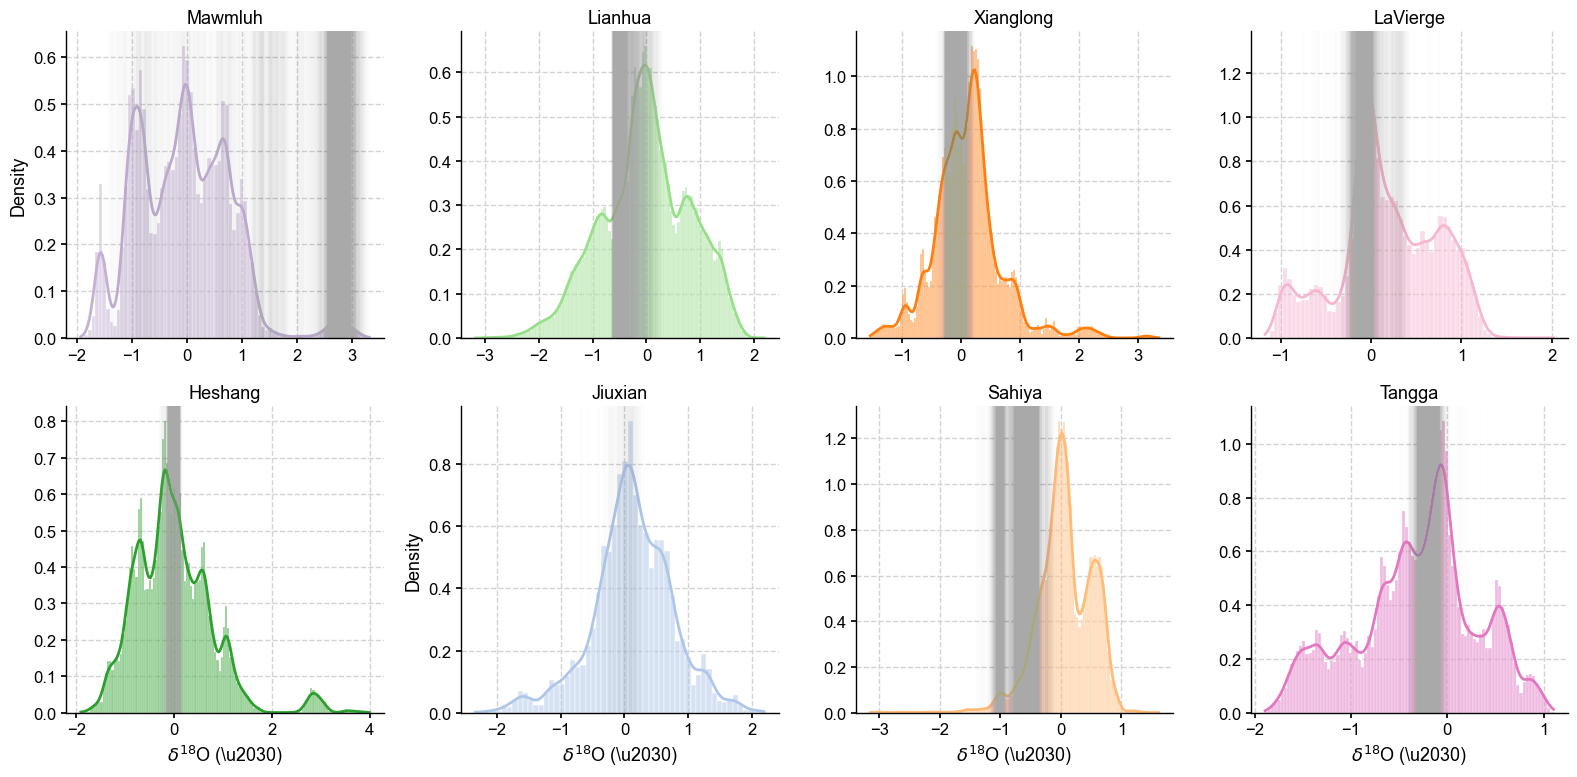

In [11]:
# Plotting

clrs = color_palette

# Create a subplot grid with 4 columns and 2 rows
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(16, 8), tight_layout=True)

# Flatten the axis array for easier indexing
axes = ax.ravel()

int_size = 200

# Iterate over each site in d18O_diff_bacon
for idx, site in enumerate(d18O_int_copra.keys()):
    # Extract the data for the current site and interval size
    s = pd.Series(d18O_int_copra[site][int_size].flatten())
    
    # Create a histogram plot using seaborn
    sns.histplot(s.dropna(), color=clrs[site], ax=axes[idx], kde=True, ec='white', stat='density')
    
    # Set the title for each subplot
    axes[idx].set_title(site, fontsize=13)
    
    # Set the y-label for the first column of subplots
    if idx in [0, 5, 10]:
        axes[idx].set_ylabel('Density', fontsize=13)
    else:
        axes[idx].set_ylabel('')
    
    # Set the tick label size for both axes
    axes[idx].tick_params(axis='both', which='major', labelsize=12)
    
    # Set the x-label for the bottom row of subplots
    if idx >= 4:
        axes[idx].set_xlabel(u'$\\delta^{18}$O (\\u2030)', fontsize=13)
    
    # Add vertical lines for each data point in the specified interval
    for i in range(d18O_int_copra[site][int_size].shape[1]):
        axes[idx].axvline(x=d18O_int_copra[site][int_size][holo_int[int_size][:-1]==4000-int_size/2, i], alpha=0.01, color='darkgray')